**Predicting Pathologies In X-Ray Images**  *--work in progress--*

The NIH Clinical Center recently released over 100,000 anonymized chest x-ray images and their corresponding data to the scientific community. The release will allow researchers across the country and around the world to freely access the datasets and increase their ability to teach computers how to detect and diagnose disease. Ultimately, this artificial intelligence mechanism can lead to clinicians making better diagnostic decisions for patients.   

https://www.nih.gov/news-events/news-releases/nih-clinical-center-provides-one-largest-publicly-available-chest-x-ray-datasets-scientific-community

https://stanfordmlgroup.github.io/projects/chexnet/

In [1]:
import pandas as pd
import numpy as np
import os
os.sys.path
from glob import glob
import random
import matplotlib.pylab as plt
import cv2
import matplotlib.gridspec as gridspec
import seaborn as sns
import zlib
import itertools
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
import keras
from keras.models import Sequential
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Activation, Dropout
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPool2D,MaxPooling2D,AveragePooling2D, BatchNormalization
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.models import model_from_json
from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D
from keras.applications.mobilenet import MobileNet

Using TensorFlow backend.
/home/alan/miniconda2/envs/tfl/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/alan/miniconda2/envs/tfl/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/alan/miniconda2/envs/tfl/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/alan/miniconda2/envs/tfl/l

Load the data

In [ ]:
PATH = os.path.abspath(os.path.join('.\DataXray\images_001')) 
# PATH = os.path.abspath(os.path.join('/media/alan/4039-01DB/data_xray/images_001')) 
SOURCE_IMAGES = os.path.join(PATH, "images")
images = glob(os.path.join(SOURCE_IMAGES, "*.png"))

images[0:10]


In [ ]:
SOURCE_IMAGES

In [ ]:
labels = pd.read_csv('.\DataXray\Data_Entry_2017.csv')
labels.head(5)

Plot a representative image

It should be noted that these images require some significant pre-processing and/or relabeling for best results.  For this exercise we will do only minimal pre-processing of the images.  See the following blogpost for more detail about specific challenges associated with this dataset: https://lukeoakdenrayner.wordpress.com/2017/12/18/the-chestxray14-dataset-problems/. 

What types of ailments are identified in these annotated X-ray images?

Convert annotated .png images into labeled numpy arrays.  Discard all images with more than one pathology.

In [ ]:
df=labels
data=df.groupby('Finding Labels').count().sort_values('Patient ID',ascending=False)
df1=data[['|' in index for index in data.index]].copy()
df2=data[['|' not in index for index in data.index]]

In [2]:
# Single Label!!!!!!!!!!!!!!
img_size = 79

def proc_images():
    """
    Returns two arrays: 
        x is an array of resized images
        y is an array of labels
    """
    NoFinding = "No Finding" #0
    Consolidation="Consolidation" #1
    Infiltration="Infiltration" #2
    Pneumothorax="Pneumothorax" #3
    Edema="Edema" # 4
    Emphysema="Emphysema" #5
    Fibrosis="Fibrosis" #6
    Effusion="Effusion" #7
    Pneumonia="Pneumonia" #8
    Pleural_Thickening="Pleural_Thickening" #9
    Cardiomegaly="Cardiomegaly" #10
    NoduleMass="Nodule" #11
    Hernia="Hernia" #12
    Atelectasis="Atelectasis"  #13 
   # RareClass = ["Edema", "Emphysema", "Fibrosis", "Pneumonia", "Pleural_Thickening", "Cardiomegaly","Hernia"]
    x = [] # images as arrays
    y = [] # labels
    WIDTH = img_size
    HEIGHT = img_size
    a0=0;a1=0;a2=0;a3=0;a4=0;a5=0;a6=0;a7=0;a8=0;a9=0;a10=0;a11=0;a12=0;a13=0;i=0  
    symbol = "|"
    num_imgs = 200
    for img in images:
        base = os.path.basename(img)
        # Read and resize image
        finding = labels["Finding Labels"][labels["Image Index"] == base].values[0]
        if a0+a1+a2+a3+a4+a5+a6+a7+a8+a9+a10+a11+a12+a13 == (num_imgs-1)*14:
            break
        if i % 5000 == 0:
                print("Iteration", i)
        if symbol in finding:
            continue
        else:
            full_size_image = cv2.imread(img)
            if NoFinding in finding:
                finding = 0
                if a0 < num_imgs:
                    y.append(finding)
                    x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
                    a0+=1
            elif Consolidation in finding:
                finding = 1
                if a1 < num_imgs:
                    y.append(finding)
                    x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
                    a1+=1
            elif Infiltration in finding:
                finding = 2
                if a2 < num_imgs:
                    y.append(finding)
                    x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
                    a2+=1
            elif Pneumothorax in finding:
                finding = 3
                if a3 < num_imgs:
                    y.append(finding)
                    x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
                    a3+=1
            elif Edema in finding:
                finding = 4
                if a4 < num_imgs:
                    y.append(finding)
                    x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
                    a4+=1
            elif Emphysema in finding:
                finding = 5
                if a5 < num_imgs:
                    y.append(finding)
                    x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
                    a5+=1
            elif Fibrosis in finding:
                finding = 6
                if a6 < num_imgs:
                    y.append(finding)
                    x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
                    a6+=1
            elif Effusion in finding:
                finding = 7
                if a7 < num_imgs:
                    y.append(finding)
                    x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
                    a7+=1
            elif Pneumonia in finding:
                finding = 8
                if a8 < num_imgs:
                    y.append(finding)
                    x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
                    a8+=1
            elif Pleural_Thickening in finding:
                finding = 9
                if a9 < num_imgs:
                    y.append(finding)
                    x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
                    a9+=1
            elif Cardiomegaly in finding:
                finding = 10
                if a10 < num_imgs:
                    y.append(finding)
                    x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
                    a10+=1
            elif NoduleMass in finding:
                finding = 11
                if a11 < num_imgs:
                    y.append(finding)
                    x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
                    a11+=1
            elif Hernia in finding:
                finding = 12
                if a12 < num_imgs:
                    y.append(finding)
                    x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
                    a12+=1
            elif Atelectasis in finding:
                finding = 13
                if a13 < num_imgs:
                    y.append(finding)
                    x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
                    a13+=1
            else:
                continue
        i+=1
    return x,y

In [ ]:
# Multi-label!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! 
img_size = 79

def proc_images():
    """
    Returns two arrays: 
        x is an array of resized images
        y is an array of labels
    """
    NoFinding = "No Finding" #0
    Consolidation="Consolidation" #1
    Infiltration="Infiltration" #2
    Pneumothorax="Pneumothorax" #3
    Edema="Edema" # 4
    Emphysema="Emphysema" #5
    Fibrosis="Fibrosis" #6
    Effusion="Effusion" #7
    Pneumonia="Pneumonia" #8
    Pleural_Thickening="Pleural_Thickening" #9
    Cardiomegaly="Cardiomegaly" #10
    NoduleMass="Nodule" #11
    Hernia="Hernia" #12
    Atelectasis="Atelectasis"  #13 
   # RareClass = ["Edema", "Emphysema", "Fibrosis", "Pneumonia", "Pleural_Thickening", "Cardiomegaly","Hernia"]
    x = [] # images as arrays
    y = [] # labels
    WIDTH = img_size
    HEIGHT = img_size
    a0=0;a1=0;a2=0;a3=0;a4=0;a5=0;a6=0;a7=0;a8=0;a9=0;a10=0;a11=0;a12=0;a13=0;a14=0;i=0  
    symbol = "|"
    num_imgs = 200
    for img in images:
        base = os.path.basename(img)
        # Read and resize image
        finding = labels["Finding Labels"][labels["Image Index"] == base].values[0]
        if a0+a1+a2+a3+a4+a5+a6+a7+a8+a9+a10+a11+a12+a13+a14 == (num_imgs-1)*15:
            break
        if i % 5000 == 0:
                print("Iteration", i)
        if symbol in finding:
            if a14 < 300:
                finding = 14*[0]
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
                a0+=1 
                if Consolidation in finding: 
                    finding[1] = 1
                if Infiltration in finding:
                    finding[2] = 1
                if Pneumothorax in finding:
                    finding[3] = 1
                if Edema in finding:
                    finding[4] = 1
                if Emphysema in finding:
                    finding[5] = 1
                if Fibrosis in finding:
                    finding[6] = 1
                if Effusion in finding:
                    finding[7] = 1
                if Pneumonia in finding:
                    finding[8] = 1
                if Pleural_Thickening in finding:
                    finding[9] = 1
                if Cardiomegaly in finding:
                    finding[10] = 1
                if NoduleMass in finding:
                    finding[11] = 1
                if Hernia in finding:
                    finding[12] = 1
                if Atelectasis in finding:
                    finding[13] = 1
                y.append(finding)

        else:
            full_size_image = cv2.imread(img)
            if NoFinding in finding:
                finding = 14*[0]
                if a0 < num_imgs:
                    finding[0] = 1
                    y.append(finding)
                    x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
                    a0+=1
            elif Consolidation in finding:
                finding = 14*[0]
                if a1 < num_imgs:
                    finding[1] = 1
                    y.append(finding)
                    x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
                    a1+=1
            elif Infiltration in finding:
                finding = 14*[0]
                if a2 < num_imgs:
                    finding[2] = 1
                    y.append(finding)
                    x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
                    a2+=1
            elif Pneumothorax in finding:
                finding = 14*[0]
                if a3 < num_imgs:
                    finding[3] = 1
                    y.append(finding)
                    x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
                    a3+=1
            elif Edema in finding:
                finding = 14*[0]
                if a4 < num_imgs:
                    finding[4] = 1
                    y.append(finding)
                    x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
                    a4+=1
            elif Emphysema in finding:
                finding = 14*[0]
                if a5 < num_imgs:
                    finding[5] = 1
                    y.append(finding)
                    x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
                    a5+=1
            elif Fibrosis in finding:
                finding = 14*[0]
                if a6 < num_imgs:
                    finding[6] = 1
                    y.append(finding)
                    x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
                    a6+=1
            elif Effusion in finding:
                finding = 14*[0]
                if a7 < num_imgs:
                    finding[7] = 1
                    y.append(finding)
                    x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
                    a7+=1
            elif Pneumonia in finding:
                finding = 14*[0]
                if a8 < num_imgs:
                    finding[8] = 1
                    y.append(finding)
                    x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
                    a8+=1
            elif Pleural_Thickening in finding:
                finding = 14*[0]
                if a9 < num_imgs:
                    finding[9] = 1
                    y.append(finding)
                    x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
                    a9+=1
            elif Cardiomegaly in finding:
                finding = 14*[0]
                if a10 < num_imgs:
                    finding[10] = 1
                    y.append(finding)
                    x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
                    a10+=1
            elif NoduleMass in finding:
                finding = 14*[0]
                if a11 < num_imgs:
                    finding[11] = 1
                    y.append(finding)
                    x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
                    a11+=1
            elif Hernia in finding:
                finding = 14*[0]
                if a12 < num_imgs:
                    finding[12] = 1
                    y.append(finding)
                    x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
                    a12+=1
            elif Atelectasis in finding:
                finding = 14*[0]
                if a13 < num_imgs:
                    finding[13] = 1
                    y.append(finding)
                    x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
                    a13+=1
            else:
                continue
        i+=1
    return x,y

In [ ]:
X,y = proc_images()
df = pd.DataFrame()
df["images"]=X
df["labels"]=y
print(len(df), df.images[0].shape)
print(type(X))

In [ ]:
df['labels']

In [3]:
import pickle
# Save and load the X and y from previous times.
# with open('newSampleXy79x79-200imgs-multilabel.pickle', 'wb') as f:
#     pickle.dump([X, y], f)
    
with open('newSampleXy79x79-200imgs-multilabel.pickle', 'rb') as f:
    X, y = pickle.load(f)
    
df = pd.DataFrame()
df["images"]=X
df["labels"]=y
print(len(df), df.images[0].shape)

2985 (79, 79, 3)


Describe new numpy arrays

In [4]:
dict_characters = {0: 'No Finding', 1: 'Consolidation', 2: 'Infiltration', 
        3: 'Pneumothorax', 4: 'Edema', 5: 'Emphysema', 6: 'Fibrosis', 7: 'Effusion', 8: 'Pneumonia', 9: 'Pleural Thickening', 10: 'Cardiomegaly', 11: "Nodule Mass", 12: 'Hernia', 13: "Atelectasis"}

print(df.head(15))
print("")
print(dict_characters)

                                               images  \
0   [[[176, 176, 176], [30, 30, 30], [0, 0, 0], [0...   
1   [[[176, 176, 176], [30, 30, 30], [0, 0, 0], [0...   
2   [[[176, 176, 176], [30, 30, 30], [0, 0, 0], [0...   
3   [[[67, 67, 67], [63, 63, 63], [72, 72, 72], [8...   
4   [[[25, 25, 25], [11, 11, 11], [11, 11, 11], [1...   
5   [[[31, 31, 31], [19, 19, 19], [17, 17, 17], [1...   
6   [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   
7   [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   
8   [[[77, 77, 77], [68, 68, 68], [68, 68, 68], [6...   
9   [[[7, 7, 7], [7, 7, 7], [7, 7, 7], [7, 7, 7], ...   
10  [[[19, 19, 19], [2, 2, 2], [2, 2, 2], [4, 4, 4...   
11  [[[59, 59, 59], [13, 13, 13], [6, 6, 6], [7, 7...   
12  [[[59, 59, 59], [13, 13, 13], [6, 6, 6], [7, 7...   
13  [[[28, 28, 28], [15, 15, 15], [12, 12, 12], [1...   
14  [[[89, 89, 89], [75, 75, 75], [61, 61, 61], [5...   

                                        labels  
0   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 

Describe the distribution of pixel intensities within a representative image

Normalize the pixel intensities between zero and one.

In [5]:
# Make the input a Numpy array, and normalize it by max pixel intensity.
X=np.array(X)
X=X/255.0

Describe distribution of class labels

In [ ]:
lab = df['labels']
dist = lab.value_counts()
sns.countplot(lab)
print(dict_characters)
print(dist)

We have imbalanced sample sizes.  This is a problem that needs to be addressed.

But for now we can proceed with a preliminary analysis.

In [6]:
# Split train and test sets.

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)

# Reduce Sample Size for DeBugging
# X_train = X_train[0:5000] 
# Y_train = Y_train[0:5000]
# X_test = X_test[0:2000] 
# Y_test = Y_test[0:2000]

In [7]:
print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)
print("Training Data Shape:", len(X_train), X_train[0].shape)
print("Testing Data Shape:", len(X_test), X_test[0].shape)
Y_trainHot = np.array(Y_train).reshape(len(Y_train),14).astype(np.float)
Y_testHot = np.array(Y_test).reshape(len(Y_test),14).astype(np.float)


Training Data Shape: (2388, 79, 79, 3)
Testing Data Shape: (597, 79, 79, 3)
Training Data Shape: 2388 (79, 79, 3)
Testing Data Shape: 597 (79, 79, 3)


In [8]:
del X, y

Now I will try to use a vanilla CNN to predict each ailment based off of the X-Ray image.

In [8]:
# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_trainHot = to_categorical(Y_train, num_classes = 14)
Y_testHot = to_categorical(Y_test, num_classes = 14)

In order to avoid having a biased model because of skewed class sizes, I will modify the class_weights parameter in order to give more weight to the rare classes.  In this case the class_weights parameter will eventually be passed to the model.fit function.

In [9]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced', np.unique(y), y)
# print(class_weight)
# class_weight = 14*[1]
print(class_weight)

[0.96785714 0.96785714 0.96785714 0.96785714 0.96785714 0.96785714
 0.96785714 0.96785714 0.96785714 0.96785714 0.96785714 0.96785714
 1.75974026 0.96785714]


In [9]:
# Helper Functions  Learning Curves and Confusion Matrix

from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_learning_curve(history):
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    #plt.clf()
    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

In [10]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
import tensorflow as tf
tf.test.gpu_device_name()


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15106925691573793488
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 4456749037723419712
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 13845772212414046925
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1568800768
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11175288431927720173
physical_device_desc: "device: 0, name: GeForce 940MX, pci bus id: 0000:01:00.0, compute capability: 5.0"
]


'/device:GPU:0'

In [ ]:

from numba import jit, cuda 
 # function optimized to run on gpu  
@jit(target ="cuda")   
def runCNNconfusion(a,b,c,d,e,f,g,h):
    # In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out
    batch_size = 128
    num_classes = f
    epochs = g
    #img_rows, img_cols = X_train.shape[1],b.shape[2]
    input_shape = (img_size, img_size, 3)
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu', input_shape = input_shape,strides=h))
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Flatten())
    #model.add(Dense(1024, activation = "relu"))
    #model.add(Dropout(0.5))
    model.add(Dense(512, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation = "softmax"))
    # Define the optimizer
    optimizer = Adam()
    model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=True,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rescale=1. / 255, #rescale
        rotation_range=40,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.4,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.4,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
    datagen.fit(a)
    history = model.fit_generator(datagen.flow(a,b, batch_size=32),
                        steps_per_epoch=len(a) / 32, epochs=epochs, class_weight = e,  validation_data = [c, d],callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0) 
    plot_learning_curve(history)
    plt.show()
    plotKerasLearningCurve()
    plt.show()
    print('\nKeras CNN #2B - accuracy:', score[1],'\n')
    Y_pred = model.predict(c)
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(Y_pred, axis=1), target_names=list(dict_characters.values())), sep='')    
    Y_pred_classes = np.argmax(Y_pred,axis = 1) 
    Y_true = np.argmax(d,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values()))
    plt.show()
runCNNconfusion(X_train, Y_trainHot, X_test, Y_testHot,class_weight,14,100,1)

In [51]:
# Build the Xception network.
with tf.device('/device:GPU:0'):

    from keras.models import Sequential
    from keras.layers import Dropout, GlobalAveragePooling2D, Dense, Dropout, Flatten,Activation
    from keras.applications.vgg16 import VGG16
    base_model = VGG16(input_shape = (img_size, img_size, 3), include_top = False, weights = 'imagenet')
    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(Dropout(0.3)) # 0.3
    model.add(Dense(256,activation=None,kernel_regularizer=keras.regularizers.l2(0.005))) # 512
    model.add(BatchNormalization())
    model.add(Activation('relu')) # 512
    model.add(Dropout(0.4)) # 0.3
    model.add(Dense(128,activation=None,kernel_regularizer=keras.regularizers.l2(0.005))) # 512
    model.add(BatchNormalization())
    model.add(Activation('relu')) # 512
    model.add(Dropout(0.4)) # 0.3
    model.add(Dense(14, activation='sigmoid'))
    # Don't train on the pretrained network.
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(loss='binary_crossentropy',optimizer=keras.optimizers.adam(lr=0.001), metrics=['binary_accuracy'])
    model.summary()
    # Train the model.
    history = model.fit(X_train, Y_trainHot, epochs = 25, verbose=1, validation_data=(X_test, Y_testHot))

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten_9 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_23 (Dense)             (None, 256)               524544    
_________________________________________________________________
batch_normalization_35 (Batc (None, 256)               1024      
_________________________________________________________________
activation_15 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 256)              

In [52]:
characters = ['No Finding', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema',
                   'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural Thickening', 
                   'Cardiomegaly', "Nodule Mass", 'Hernia', "Atelectasis"]


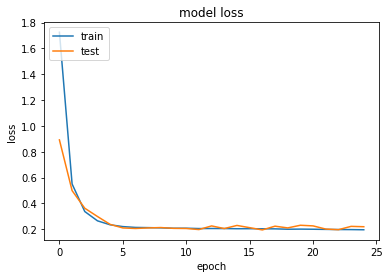

<Figure size 432x288 with 0 Axes>

In [53]:
# Define function to plot results.
def history_plot(history):
#     plt.plot(history.history['binary_accuracy'])
#     plt.plot(history.history['val_binary_accuracy'])
#     plt.title('model accuracy')
#     plt.ylabel('accuracy')
#     plt.xlabel('epoch')
#     plt.legend(['train', 'test'], loc='upper left')
#     plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    plt.savefig('./loss_curve.png')
history_plot(history)


2388/2388 [==============================] - 16s 7ms/step


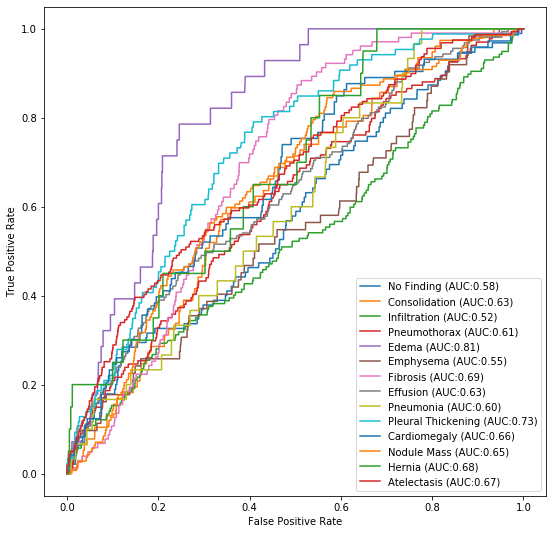

In [54]:
predictions = model.predict(X_train, batch_size = 32, verbose = True)
# Plot ROC curve
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(characters):
    fpr, tpr, thresholds = roc_curve(Y_trainHot[:,idx].astype(int), predictions[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.savefig('./roc-trainVGG.png')

597/597 [==============================] - 4s 6ms/step


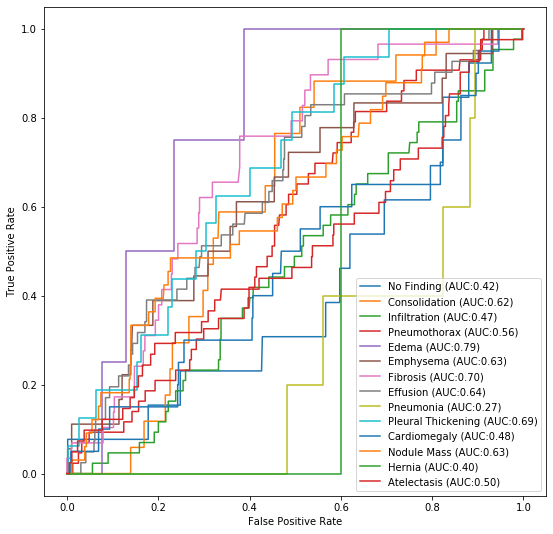

In [55]:
predictions = model.predict(X_test, batch_size = 32, verbose = True)
# Plot ROC curve
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(characters):
    fpr, tpr, thresholds = roc_curve(Y_testHot[:,idx].astype(int), predictions[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('barely_trained_net.png')
plt.savefig('./roc-testVGG.png')

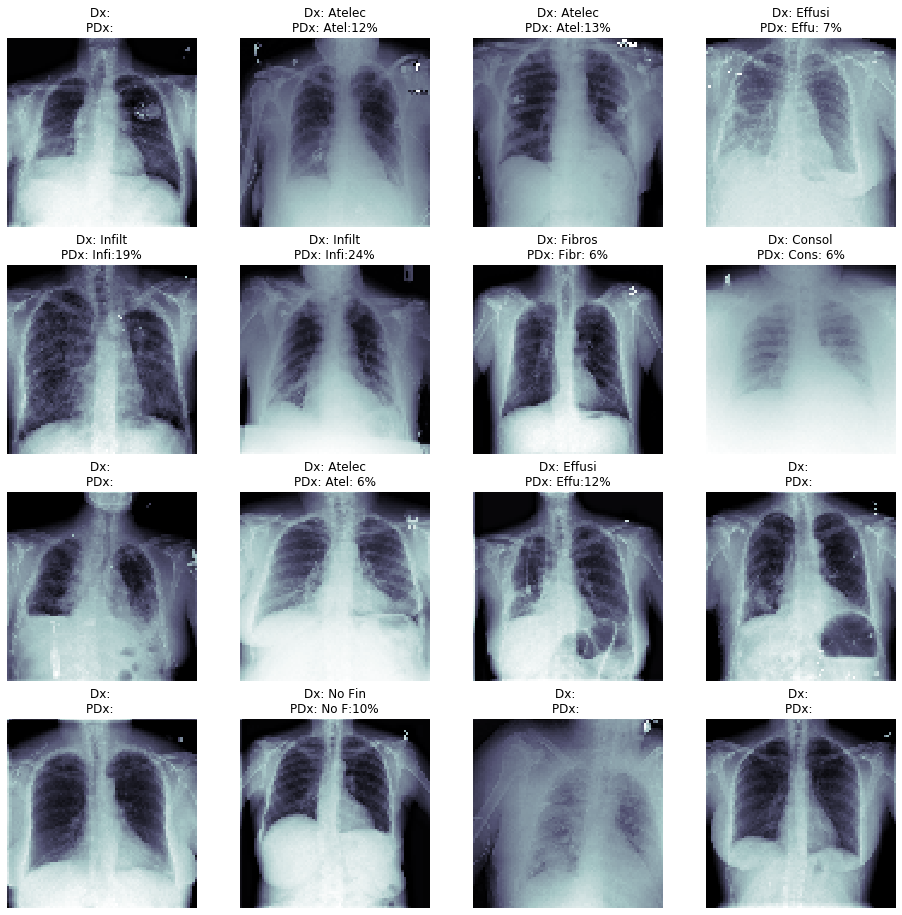

In [56]:
# Plot some images.
sickest_idx = np.argsort(np.sum(Y_testHot, 1)<1)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (idx, c_ax) in zip(sickest_idx, m_axs.flatten()):
    c_ax.imshow(X_train[idx, :,:,0], cmap = 'bone')
    stat_str = [n_class[:6] for n_class, n_score in zip(characters, 
                                                                  Y_trainHot[idx]) 
                             if n_score>0.5]
    pred_str = ['%s:%2.0f%%' % (n_class[:4], p_score*100)  for n_class, n_score, p_score in zip(characters, 
                                                                  Y_trainHot[idx], predictions[idx]) 
                             if (n_score>0.5) or (p_score>0.5)]
    c_ax.set_title('Dx: '+', '.join(stat_str)+'\nPDx: '+', '.join(pred_str))
    c_ax.axis('off')
fig.savefig('trained_img_predictions.png')

In [44]:


# from numba import jit, cuda 
#  # function optimized to run on gpu  
# @jit(target ="cuda")  

from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Activation
weight_path = './keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
map_characters=dict_characters
class_weight=14*[1]

def vgg16network(a,b,c,d,e,f,g):
    num_class = f
    epochs = g
    base_model = VGG16(weights='imagenet',
        include_top=False, input_shape=(img_size, img_size, 3))
    # Add a new top layer
    x = base_model.output
    x = Dense(128, activation =None, use_bias=False, kernel_regularizer=keras.regularizers.l2(0.0))(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.1)(x)
    predictions = Dense(num_class, activation='sigmoid')(x)
    # This is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)
    # First: train only the top layers (which were randomly initialized)
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(loss='binary_crossentropy', 
                  optimizer=keras.optimizers.adam(lr=0.001), metrics=['accuracy'])
    callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
    model.summary()
    history = model.fit(a,b, epochs=epochs,class_weight=e, batch_size = 32, validation_data=(c,d), verbose=1,callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras VGG16 - accuracy:', score[1], '\n')
    y_pred = model.predict(c)
#     print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='') 
#     Y_pred_classes = np.argmax(y_pred,axis = 1) 
#     Y_true = np.argmax(d,axis = 1) 
#     confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

#     plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))
#     plt.show()
    return model
vgg16network(X_train, Y_trainHot, X_test, Y_testHot,class_weight,14,10)



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 79, 79, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 79, 79, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 79, 79, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 39, 39, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 39, 39, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 39, 39, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 19, 19, 128)       0         
__________

ValueError: Error when checking target: expected dense_10 to have 4 dimensions, but got array with shape (2388, 14)

In [13]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
weight_path = './keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
map_characters=dict_characters
 
def vgg16network(a,b,c,d,e,f,g):
    num_class = f
    epochs = g
    base_model = VGG16(weights='imagenet',
        include_top=False, input_shape=(img_size, img_size, 3))
    # Add a new top layer
    x = base_model.output
    x = Flatten()(x)
#     x = Dense(512, use_bias=False, activation = None,activity_regularizer=keras.regularizers.l2(0.001)
#              ,kernel_regularizer=keras.regularizers.l2(0))(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)
#     x = Dropout(0.5)(x)
    x = Dense(64, use_bias=False, activation = None,activity_regularizer=keras.regularizers.l2(0.001)
             ,kernel_regularizer=keras.regularizers.l2(0))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(32, use_bias=False, activation = None,activity_regularizer=keras.regularizers.l2(0.001)
             ,kernel_regularizer=keras.regularizers.l2(0))(x)
    x = BatchNormalization()(x)
    x = Activation('sigmoid')(x)
#     x = Dropout(0.5)(x)
    predictions = Dense(num_class, activation='softmax')(x)
    # This is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)
    # First: train only the top layers (which were randomly initialized)
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(loss='mse',
                  optimizer=keras.optimizers.sgd(lr=0.005), metrics=['accuracy'])
    callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
    model.summary()
    history = model.fit(a,b, epochs=epochs, class_weight=e, validation_data=(c,d), verbose=1,callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras VGG16 #2 - accuracy:', score[1], '\n')
    y_pred = model.predict(c)
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')
    Y_pred_classes = np.argmax(y_pred,axis = 1)
    Y_true = np.argmax(d,axis = 1)
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
   
    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))
    plt.show()
    return model
vgg16network(X_train, Y_trainHot, X_test, Y_testHot,class_weight,14,200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 79, 79, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 79, 79, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 79, 79, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 39, 39, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 39, 39, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 39, 39, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 19, 19, 128)       0         
__________

KeyboardInterrupt: 

In [ ]:


# from numba import jit, cuda 
#  # function optimized to run on gpu  
# @jit(target ="cuda")  

from keras.applications.vgg16 import VGG16
from keras.models import Model
weight_path = './keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
map_characters=dict_characters
class_weights = []

def vgg16network(a,b,c,d,e,f,g):
    num_class = f
    epochs = g
    base_model = VGG16(weights='imagenet',
        include_top=False, input_shape=(img_size, img_size, 3))
    # Add a new top layer
    x = base_model.output
#     x = BatchNormalization()(x)
#     x = Dropout(0.5)(x)
    x = Flatten()(x)
    x = Dense(512, activation = "relu",kernel_regularizer=keras.regularizers.l2(0.0)
             ,bias_regularizer=keras.regularizers.l2(0.0))(x)
#     x = BatchNormalization()(x)
#     x = Dropout(0.5)(x)
    x = Dense(128, activation = "relu",kernel_regularizer=keras.regularizers.l2(0.0)
             ,bias_regularizer=keras.regularizers.l2(0.0))(x)
#     x = Dropout(0.25)(x)
    predictions = Dense(num_class, activation='softmax')(x)
    # This is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)
    # First: train only the top layers (which were randomly initialized)
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(loss='binary_crossentropy', 
                  optimizer=keras.optimizers.adam(lr=0.001), metrics=['accuracy'])
    callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
    model.summary()
    history = model.fit(a,b, epochs=epochs, validation_data=(c,d), verbose=1,callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras VGG16 - accuracy:', score[1], '\n')
    y_pred = model.predict(c)
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='') 
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(d,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_learning_curve(history)
    plotKerasLearningCurve()
    plt.show()
    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))
    plt.show()
    return model
vgg16network(X_train, Y_trainHot, X_test, Y_testHot,class_weight,14,200)

In [ ]:
Y_trainHot = Y_train
Y_testHot = Y_test
img_size = 79
Y_testHot

In [ ]:
# Build the VGG16 network.
from keras.models import Sequential
from keras.layers import Dropout, GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.applications.vgg16 import VGG16

base_model = VGG16(include_top=False, weights='imagenet', input_tensor=None, 
      input_shape=(img_size, img_size, 3), pooling=None)

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5)) # 0.3
model.add(Dense(512))
model.add(Dropout(0.5)) # 0.3
model.add(Dense(activation='sigmoid'))
# for layer in base_model.layers:
#     layer.trainable = False
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
model.summary()

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

In [ ]:
visualize_model(model_ft)


The imbalance in our dataset has resulted in a biased model.  I tried to prevent this by modifying the class_weights parameter and using in the model.fit function but apparently that was not enough.  Now I will try to compensate for the imbalanced sample size by oversampling or upsampling the minority classes.

In [ ]:
lab = df['labels']
dist = lab.value_counts()
sns.countplot(lab)
print(dict_characters)

It is very import to do upsampling AFTER the train_test_split function otherwise you can end up with values in the testing dataset that are related to the values within the training dataset.

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)
# Reduce Sample Size for DeBugging
X_train = X_train[0:5000] 
Y_train = Y_train[0:5000]
X_test = X_test[0:2000] 
Y_test = Y_test[0:2000]

In [ ]:
# Make Data 1D for compatability upsampling methods
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)
print("X_train Shape: ",X_train.shape)
print("X_test Shape: ",X_test.shape)
print("X_trainFlat Shape: ",X_trainFlat.shape)
print("X_testFlat Shape: ",X_testFlat.shape)

In [ ]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(ratio='auto')
X_trainRos, Y_trainRos = ros.fit_sample(X_trainFlat, Y_train)
X_testRos, Y_testRos = ros.fit_sample(X_testFlat, Y_test)

# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_trainRosHot = to_categorical(Y_trainRos, num_classes = 14)
Y_testRosHot = to_categorical(Y_testRos, num_classes = 14)
print("X_train: ", X_train.shape)
print("X_trainFlat: ", X_trainFlat.shape)
print("X_trainRos Shape: ",X_trainRos.shape)
print("X_testRos Shape: ",X_testRos.shape)
print("Y_trainRosHot Shape: ",Y_trainRosHot.shape)
print("Y_testRosHot Shape: ",Y_testRosHot.shape)

In [ ]:
for i in range(len(X_trainRos)):
    height, width, channels = 64,64,3
    X_trainRosReshaped = X_trainRos.reshape(len(X_trainRos),height,width,channels)
print("X_trainRos Shape: ",X_trainRos.shape)
print("X_trainRosReshaped Shape: ",X_trainRosReshaped.shape)

for i in range(len(X_testRos)):
    height, width, channels = 64,64,3
    X_testRosReshaped = X_testRos.reshape(len(X_testRos),height,width,channels)
print("X_testRos Shape: ",X_testRos.shape)
print("X_testRosReshaped Shape: ",X_testRosReshaped.shape)

In [ ]:
dfRos = pd.DataFrame()
dfRos["labels"]=Y_trainRos
labRos = dfRos['labels']
distRos = lab.value_counts()
sns.countplot(labRos)
print(dict_characters)

Now we have a much more even distriution of sample sizes for each of our 7 ailments (plus an 8th category for other/typos).  This should help make our model less biased in favor of the majority class (0=No Finding).

In [ ]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced', np.unique(y), y)
print("Old Class Weights: ",class_weight)
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced', np.unique(Y_trainRos), Y_trainRos)
print("New Class Weights: ",class_weight)

Our model can predict pathologies in x-ray images with an accuracy rate that is much better than random chance but there is still a lot of room for improvement.  Please see the [following blogpost](https://lukeoakdenrayner.wordpress.com/2017/12/18/the-chestxray14-dataset-problems/) for more detail about specific challenges associated with this dataset . 

In [ ]:
from keras.applications.resnet50 import ResNet50
from keras.models import Model
weight_path = './keras-pretrained-models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
im_size = 64
map_characters=dict_characters  
def ResNet50(a,b,c,d,e,f,g):
    num_class = f
    epochs = g
    base_model = ResNet50(#weights='imagenet',
        weights = weight_path, include_top=False, input_shape=(im_size, im_size, 3))
    # Add a new top layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.7)(x)
    x = Flatten()(x)
    predictions = Dense(num_class, activation='softmax')(x)
    # This is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)
    # First: train only the top layers (which were randomly initialized)
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(loss='categorical_crossentropy', 
                  optimizer=keras.optimizers.RMSprop(lr=0.0001), 
                  metrics=['accuracy'])
    callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
    model.summary()
    model.fit(a,b, epochs=epochs, class_weight=e, validation_data=(c,d), verbose=1,callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #2 - accuracy:', score[1], '\n')
    y_pred = model.predict(c)
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='') 
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(d,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plotKerasLearningCurve()
    plt.show()
    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))
    plt.show()
    return model
ResNet50(X_train, Y_trainHot, X_test, Y_testHot,class_weight,14,15)